In [2]:
import matplotlib.pyplot as plt
from arch import univariate
from arch import arch_model
import pandas as pd
import numpy as np
import statsmodels.graphics.tsaplots as tsaplots
import seaborn as sns
from pyswarm import pso
%matplotlib inline

In [3]:
a = pd.read_csv('appl.csv')

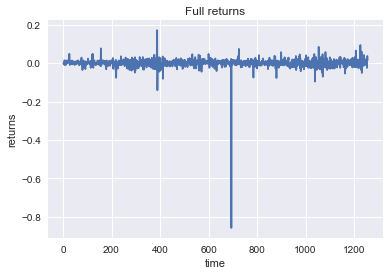

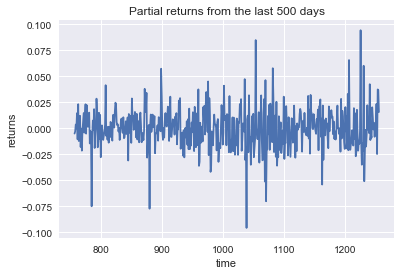

In [4]:
# Calculating returns
returns = a['Open'][:-1].values / a['Open'][1:] - 1

# Plotting the returns
plt.figure(1)
plt.plot(returns)
plt.xlabel('time')
plt.ylabel('returns')
plt.title('Full returns')
plt.show()

returns = returns[-500:]
plt.figure(2)
plt.plot(returns)
plt.xlabel('time')
plt.ylabel('returns')
plt.title('Partial returns from the last 500 days')
plt.show()

# We will work with these returns from now on

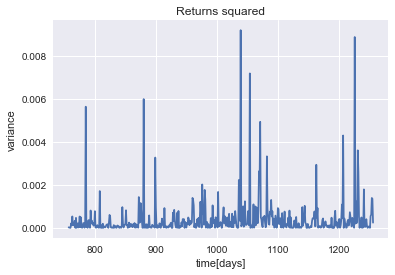

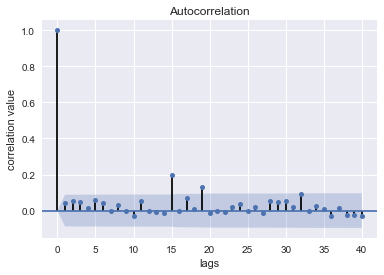

In [5]:
# Plotting the returns squared
returns_sq = returns**2
plt.plot(returns_sq)
plt.xlabel('time[days]')
plt.ylabel('variance')
plt.title('Returns squared')
plt.show()

# Testing hypothesis: Are there GARCH effects?
tsaplots.plot_acf(returns_sq,lags=40)
plt.xlabel('lags')
plt.ylabel('correlation value')
plt.show()

In [6]:
# Calculating the model GARCH(1,1)
a = arch_model(returns,p=1,q=1)
res = a.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     54,   Neg. LLF: -1263.4474704670906
Iteration:     10,   Func. Count:     97,   Neg. LLF: -1263.8480912190234
Iteration:     15,   Func. Count:    133,   Neg. LLF: -1264.5892146816748
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1264.59052479
            Iterations: 21
            Function evaluations: 152
            Gradient evaluations: 18
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   Open   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                1264.59
Distribution:                  Normal   AIC:                          -2521.18
Method:            Maximum Likelihood   BIC:                          -2504.32
                                        No. Observations:                  500
Date:            

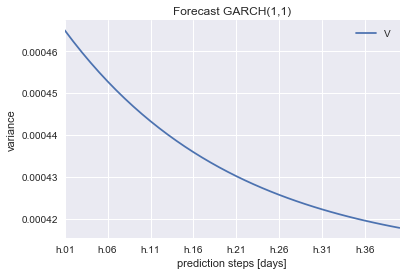

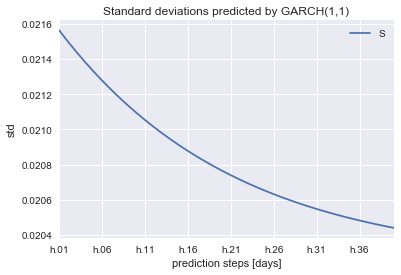

In [7]:
# Make predictions of Garch(1,1)
forecasts = res.forecast(horizon=40)

# Plot predictions of Garch(1,1)
forecasts.variance.dropna().T.plot()
plt.legend('V')
plt.xlabel('prediction steps [days]')
plt.ylabel('variance')
plt.title('Forecast GARCH(1,1)')
plt.show()


(forecasts.variance.dropna().T ** 0.5).plot()
plt.title('Standard deviations predicted by GARCH(1,1)')
plt.xlabel('prediction steps [days]')
plt.ylabel('std')
plt.legend('S')
plt.show()
# plt.show()

In [8]:
# Print confidence intervals for the model`s coefficient
res.conf_int()

,lower,upper
mu,-0.001069,0.002658
omega,0.000020,0.000020
alpha[1],-0.012275,0.119180
beta[1],0.838978,0.955738


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


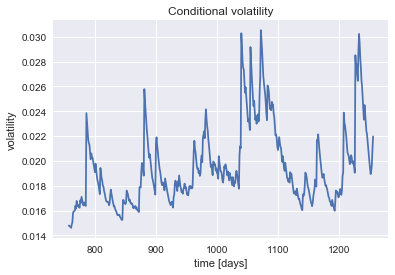

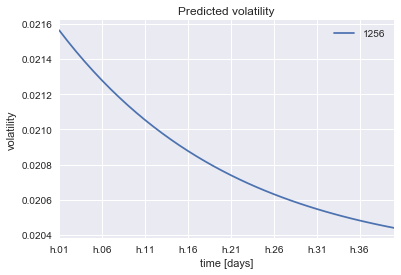

In [9]:
plt.figure(1)
plt.plot(res.conditional_volatility)
plt.title('Conditional volatility')
plt.xlabel('time [days]')
plt.ylabel('volatility')
plt.hold()

(forecasts.variance.dropna().T ** 0.5).plot()
plt.title('Predicted volatility')
plt.xlabel('time [days]')
plt.ylabel('volatility')
plt.show()


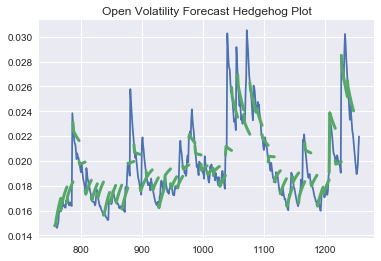

In [10]:
# Hedgehog plotting volatilities
res.hedgehog_plot()
plt.show()

In [11]:
# ax = sns.tsplot()
# plt.show()
# Creating a metric function for evalating the adequacy. We want to have the minimum std_err, meaning the maximum
# precision. The ideal value for std_err is zero. The ideal score is 1.
std_mul = 1
print("std_err for each coef of the model:")
for std in res.std_err:
    std_mul *= np.exp(std)
    print("\t Std: ",std)
    
print("Our score for this model is: ",std_mul)

std_err for each coef of the model:
	 Std:  0.000950754099566
	 Std:  4.24234597365e-10
	 Std:  0.0335351396319
	 Std:  0.0297862255173
Our score for this model is:  1.06638254295


In [12]:
# Having this value, we want to know if we could find another model that can explain better than the actual model 
# the results/returns we have. For this, we would solve an optimization problem

# we impose some limits on the garch model such that the [p&q] are in [1,30]
lb=[1,1]
ub=[4,4]

def objective_function(x):
    p_i = np.ceil(x[0])
    q_i = np.ceil(x[1])
    a = arch_model(returns,p=p_i,q=q_i)
    garch_model = a.fit(update_freq=5,disp='off') 
    std_mul = 1 
    for std in garch_model.std_err:
        std_mul *= np.exp(std)
    return std_mul

# This objective_function is isomorphic equivalent to a precision criterion
# Now let`s solve the problem to find the best model (according to our accuracy criterion <-> high precision) using PSO
# x_opt, f_opt = pso(objective_function,lb,ub,ieqcons=[],maxiter=100)
# x_opt, f_opt = pso(objective_function, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={},
#     swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=1e-2,
#     minfunc=1e-2, debug=False)

minim = 1000
for i in range(10):
    for j in range(10):
        aux = objective_function([i+1,j+1])
        if (minim >= aux):
            minim = aux
            indici = [i,j]
        
    
# print(x_opt)
# print(objective_function([4,2]))

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:451: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = zeros((num_constraints.sum(), num_params))
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:461: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a[r_st:r_en, c_st:c_en] = c[0]
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:298: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return x[:km], x[km:km + kv], x[km + kv:]
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:298: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return x[:km], x[km:km + kv], x[km + kv:]
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:451: VisibleDepreca

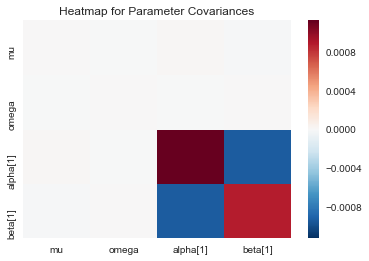

                    mu         omega      alpha[1]       beta[1]
mu        9.039334e-07 -1.839362e-13  1.134011e-05 -9.088641e-06
omega    -1.839362e-13  1.799750e-19 -1.339572e-11  1.039031e-11
alpha[1]  1.134011e-05 -1.339572e-11  1.124606e-03 -9.383371e-04
beta[1]  -9.088641e-06  1.039031e-11 -9.383371e-04  8.872192e-04


In [13]:
# Plotting the covariance parameters
sns.heatmap(res.param_cov)
plt.title('Heatmap for Parameter Covariances')
plt.show()

# Numerical covariance matrix
print(res.param_cov)

In [14]:
# Print the parameters of the model
res.params

mu          0.000795
omega       0.000020
alpha[1]    0.053453
beta[1]     0.897358
Name: params, dtype: float64

In [15]:
# Print pvalues
res.pvalues

mu           4.031471e-01
omega        0.000000e+00
alpha[1]     1.109515e-01
beta[1]     2.173003e-199
Name: pvalues, dtype: float64

In [16]:
# Print standard error to understand better how precise is this model
res.std_err

mu          9.507541e-04
omega       4.242346e-10
alpha[1]    3.353514e-02
beta[1]     2.978623e-02
Name: std_err, dtype: float64

In [17]:
# Print the optimal model from GARCH(p,q) ,p,q \in {0,10}, meaning from the first 100 models the best according to
# the cost function we imposed is GARCH(1,1)
print(np.array(indici)+1)

[1 1]
